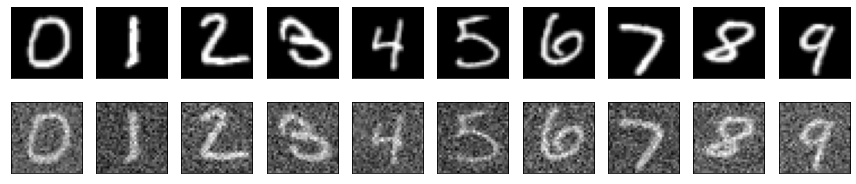

In [2]:
# %% imports
# pytorch
import torch
from torchvision import transforms,datasets
from torch.utils.data import Dataset,DataLoader
from tqdm.notebook import tqdm
from ipywidgets import IntProgress

# pyplot
import matplotlib.pyplot as plt

# %% Noisy MNIST dataset
class Noisy_MNIST(Dataset):
    # initialization of the dataset
    def __init__(self, split,data_loc,noise=0.5):
        # save the input parameters
        self.split    = split 
        self.data_loc = data_loc
        self.noise    = noise
        
        if self.split == 'train':
            Train = True
        else:
            Train = False
            
        # get the original MNIST dataset   
        Clean_MNIST = datasets.MNIST(self.data_loc, train=Train, download=True)
        
        # reshuffle the test set to have digits 0-9 at the start
        if self.split == 'train':
            data = Clean_MNIST.data.unsqueeze(1)
        else:
            data = Clean_MNIST.data.unsqueeze(1)
            idx = torch.load('test_idx.tar')
            data[:,:] = data[idx,:]
            
        
        # reshape and normalize
        resizer = transforms.Resize(32)
        resized_data = resizer(data)*1.0
        normalized_data = 2 *(resized_data/255) - 1
        #normalized_data = (resized_data - 33)/74
        
        # create the data
        self.Clean_Images = normalized_data
        self.Noisy_Images = normalized_data + torch.randn(normalized_data.size())*self.noise
        self.Labels       = Clean_MNIST.targets
    
    # return the number of examples in this dataset
    def __len__(self):
        return self.Labels.size(0)
    
    # create a a method that retrieves a single item form the dataset
    def __getitem__(self, idx):
        clean_image = self.Clean_Images[idx,:,:,:]
        noisy_image = self.Noisy_Images[idx,:,:,:]
        label =  self.Labels[idx]
        
        return clean_image,noisy_image,label
    
# %% dataloader for the Noisy MNIST dataset
def create_dataloaders(data_loc, batch_size):
    Noisy_MNIST_train = Noisy_MNIST("train", data_loc)
    Noisy_MNIST_test  = Noisy_MNIST("test" , data_loc)
    
    
    
    Noisy_MNIST_train_loader =  DataLoader(Noisy_MNIST_train, batch_size=batch_size, shuffle=True,  drop_last=False)
    Noisy_MNIST_test_loader  =  DataLoader(Noisy_MNIST_test , batch_size=batch_size, shuffle=False, drop_last=False)
    
    # These lines are added by me(Yunus) for creating a validation set
    Noisy_MNIST_val  = Noisy_MNIST("val" , data_loc)
    Noisy_MNIST_val_loader  =  DataLoader(Noisy_MNIST_val , batch_size=batch_size, shuffle=True, drop_last=False)
    
    return Noisy_MNIST_train_loader, Noisy_MNIST_test_loader, Noisy_MNIST_val_loader

# %% test if the dataloaders work
if __name__ == "__main__":
    # define parameters
    data_loc = 'D://5LSL0-Datasets' #change the datalocation to something that works for you
    batch_size = 64
    
    # get dataloader
    train_loader, test_loader,__ = create_dataloaders(data_loc, batch_size)
    
    # get some examples
    examples = enumerate(test_loader)
    _, (x_clean_example, x_noisy_example, labels_example) = next(examples)
    # use these example images througout the assignment as the first 10 correspond to the digits 0-9
    
    # show the examples in a plot
    plt.figure(figsize=(12,3))
    for i in range(10):
        plt.subplot(2,10,i+1)
        plt.imshow(x_clean_example[i,0,:,:],cmap='gray')
        plt.xticks([])
        plt.yticks([])
        
        plt.subplot(2,10,i+11)
        plt.imshow(x_noisy_example[i,0,:,:],cmap='gray')
        plt.xticks([])
        plt.yticks([])
    
    plt.tight_layout()
    plt.savefig("data_examples.png",dpi=300,bbox_inches='tight')
    plt.show()

In [3]:
print(x_clean_example.squeeze().shape)
print(labels_example.shape)

torch.Size([64, 32, 32])
torch.Size([64])


In [4]:
# Exc 1b)
import torch.nn as nn
import numpy as np
import os
import torch.optim as optim

In [29]:
class FFNN_1b(nn.Module):
    """
    A simple Feed Forward Neural Network
    
    Param
    ------------
    input_size : int (default = 32*32)         
        The length of the datasets which is width*height)
    n_hidden : int (default: 200)
        Number of hidden units.
    n_classes: int  (default = 10)        
        Number of the final classes, in our case 0-9 thus 10 classes.
    """
    def __init__(self, input_size=32*32, hidden_size= 400, n_classes=10):
        super().__init__()
        
        self.flat = nn.Flatten()
        # First fully connected layer
        self.fc1 = nn.Linear(input_size, 400)

        # Second fully connected layer
        self.fc2 = nn.Linear(400, 200)
        self.fc3 = nn.Linear(200, 500)
        self.fc4 = nn.Linear(500, input_size)
#         self.fc3 = nn.Linear(input_size, input_size)
        #no activation functions yet
    def forward(self, x):
        # forward always defines connectivity
        x = self.flat(x)
        x = self.fc2(self.fc1(x))
        y = self.fc4(self.fc3(x))
        return y
    
    def predict(self,x):
        """Predict class labels
        Parameters
        -----------
        X : array, shape = [n_samples, n_features]
            Input layer with original features.
        Returns:
        ----------
        y_pred : array, shape = [n_samples]
            Predicted class labels.
        """
        # Implement prediction here
        a_out = self.forward(x).detach().numpy()
        result = np.zeros(len(a_out))
        for i in range(len(a_out)):
            j = np.argmax(a_out[i])
            result[i] = j
        y_pred = result
        return y_pred
    
model = FFNN_1b()



### Q 1.c)

For the network to start training, we also need an optimiser.
##### What is the goal of an optimiser within a Neural Network?
* It updates the weights based on the loss and the chosen algorithm to minimize the overall loss and increase the accuracy.

For the implementation, start with using the SGD (Stochastic Gradient Descent). This has similarities to the Steepest Gradient Descent algorithm.
##### What are the similarities and differences between the two optimisers?
* wekrjlkewrj

Start with a small learning rate to begin with. Once the model has been set up, make
sure you compile it.

In [128]:
## 1c)
learning_rate = 1e-2 # small learning rate
optimizer = optim.SGD(model.parameters(), lr=learning_rate)  ## SGD optimizer
criterion = nn.MSELoss()
epochs = 200

### Q 1.d)

During training, make sure that you save the weights from your model to a folder, you
may look up the code on pytorch’s website. To ensure that your model can actually
run, make a prediction with the untrained network using the test set (after splitting
your data into the training-validation-test sets).

Plot the prediction alongside the test data. Comment on the prediction of the untrained
model. 
##### Why does it look the way it does?
* wkerjwekrj

In [7]:
## create the dataloaders
# define parameters
data_loc = 'D://5LSL0-Datasets' #change the datalocation to something that works for you
batch_size = 64

# get dataloader
train_loader, test_loader, val_loader= create_dataloaders(data_loc, batch_size)

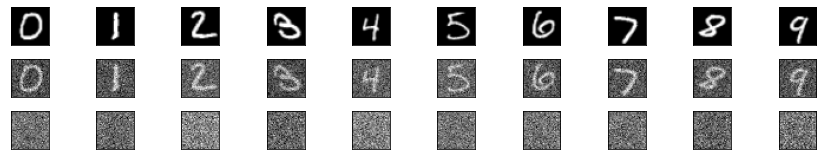

In [129]:
# define parameters
data_loc = 'D://5LSL0-Datasets' #change the datalocation to something that works for you
batch_size = 64
    
# get dataloader
test_loader
    
# get some examples
examples = enumerate(test_loader)
_, (x_clean_example, x_noisy_example, labels_example) = next(examples)

# Fill your architecture with the trained weights
device = torch.device('cpu')
model = model = FFNN_1b()
model = model.to(device=device)
with torch.no_grad():
    score_noisy = model(x_noisy_example).resize(64,1,32,32).cpu()
#     score_noisy_untrained = model_untrained(x_noisy_example).resize(64,1,32,32).cpu()



    # show the examples in a plot
    plt.figure(figsize=(12,3))
    for i in range(10):
        plt.subplot(4,10,i+1)
#         plt.set_title('Clean Test Data')
        plt.imshow(x_clean_example[i,0,:,:],cmap='gray')
        plt.xticks([])
        plt.yticks([])
#         plt.title('Pred %d '% pred_clean[i].item())

        plt.subplot(4,10,i+11)
#         plt.set_title('Noisy Test Data')
        plt.imshow(x_noisy_example[i,0,:,:],cmap='gray')
        plt.xticks([])
        plt.yticks([])
    
        plt.subplot(4,10, i+21)
#         plt.set_title('Predicted for trained')
        plt.imshow(score_noisy[i,0,:,:],cmap='gray')
        plt.xticks([])
        plt.yticks([])

plt.tight_layout()
plt.savefig("data_examples.png",dpi=300,bbox_inches='tight')
plt.show()

In [50]:
def check_accuracy(loader, model):
    print('Checking accuracy validation set')
    with torch.no_grad():
        running_loss_val = 0.0
#         Set the model to evaluation mode
        model.eval()

        for data in val_loader:
            # validation on noisy part or not
            x,xn,_ = data

            # cast the inputs to the device
            x = x.to(device=device, dtype=dtype)
            xn = xn.to(device=device, dtype=dtype)
            m = nn.Flatten()
            y = m(xn)

            output = model(x)
            loss = criterion(output, y)
            running_loss_val += loss.item()
        val_epoch_loss = running_loss_val/len(val_loader)
    return val_epoch_loss
#     print('Validation Loss', eval_dic['Loss_v'][i])

In [103]:


#Get the dataloaders
train_loader, test_loader, val_loader= create_dataloaders(data_loc, batch_size)

# Import the model
model = FFNN_1b()


# noise = True # If you want to train on the noisy data

# Parameters
batch_size = 64
epochs = 500
    
    # learning rate
learning_rate = 1e-2 
    #Loss-function
criterion = nn.MSELoss()
    #optimizer
optimizer = optim.SGD(model.parameters(), lr=learning_rate)  ## SGD optimizer


# Imports
import torch.nn.functional as F  # useful stateless functions

#Get the dataloaders
train_loader, test_loader, val_loader= create_dataloaders(data_loc, batch_size)

# flags
write_to_file = True # if you want to save the model paramters after training
USE_GPU = True # If you want to use GPU

epochs = 500

# trainer
dtype = torch.float32
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

model = model.to(device=device)

losses = []
losses_val = []

# create dictionary to keep track of training scores
eval_dic = {'Loss_t': [], 'train_acc': [],'Loss_v': [], 'valid_acc': []}
loss_train = []
loss_val = []

for i in range(epochs):
    running_loss = 0.0
    # train and compute the training loss
    for t, data in enumerate(train_loader):
        model.train() # put the model in training mode, only important for batchnorm- and dropout-layers
        x,xn,_ = data
        
        # cast the inputs to the device
        x = x.to(device=device, dtype=dtype)
        xn = xn.to(device=device, dtype=dtype)
        m = nn.Flatten()
        y = m(xn)
#         print(y.size())
        ######################## Training pass #################################
       
        # Zero out all of the parameter gradients for the variables which the optimizer
        # will update.
        optimizer.zero_grad()
        
        # Forward pass get the output prediction and the loss
        output = model(x)
        loss = criterion(output, y)

        # This is the backwards pass: compute the gradient of the loss with
        # respect to each  parameter of the model.
        loss.backward()
        
        # Actually update the parameters of the model using the gradients
        # computed by the backwards pass.
        optimizer.step()
        
        running_loss += loss.item()
    
    train_epoch_loss = running_loss#/len(train_loader)
    eval_dic['Loss_t'].append(train_epoch_loss)
    
#     print(eval_dic['Loss_t'][i])
#         else:
#             test_loss = 0
#             accuracy = 0
        
            ########################### Validation pass ####################################
    # Turn off gradients for validation, saves memory and computation
    with torch.no_grad():
        running_loss_val = 0.0
#         Set the model to evaluation mode
        model.eval()

        for data in val_loader:
            # validation on noisy part or not
            x,xn,_ = data

            # cast the inputs to the device
            x = x.to(device=device, dtype=dtype)
            xn = xn.to(device=device, dtype=dtype)
            m = nn.Flatten()
            y = m(xn)

            output = model(x)
            loss = criterion(output, y)
            running_loss_val += loss.item()
        val_epoch_loss = running_loss_val#/len(val_loader)
        eval_dic['Loss_v'].append(val_epoch_loss)
    print('Epoch', i)
    print('Training Loss', eval_dic['Loss_t'][i])
    print('Checking accuracy validation set')
    print('Validation Loss', eval_dic['Loss_v'][i])
   
    # Save the model paramters
    if write_to_file:        
        # Save the weights of the model to a .pt file
        torch.save(model.state_dict(), os.path.join("./", "Saved_Model.pth"))

Epoch 0
Training Loss 544.6194526553154
Checking accuracy validation set
Validation Loss 74.06587275862694
Epoch 1
Training Loss 439.03654116392136
Checking accuracy validation set
Validation Loss 73.29608723521233
Epoch 2
Training Loss 434.2386799454689
Checking accuracy validation set
Validation Loss 72.37941813468933
Epoch 3
Training Loss 428.06521943211555
Checking accuracy validation set
Validation Loss 71.13854444026947
Epoch 4
Training Loss 419.7056295275688
Checking accuracy validation set
Validation Loss 69.51510939002037
Epoch 5
Training Loss 409.2242929637432
Checking accuracy validation set
Validation Loss 67.58974066376686
Epoch 6
Training Loss 397.932480186224
Checking accuracy validation set
Validation Loss 65.67475646734238
Epoch 7
Training Loss 387.1685747206211
Checking accuracy validation set
Validation Loss 63.92635199427605
Epoch 8
Training Loss 377.43938648700714
Checking accuracy validation set
Validation Loss 62.35753446817398
Epoch 9
Training Loss 368.986519008

Epoch 76
Training Loss 278.58965170383453
Checking accuracy validation set
Validation Loss 46.47882595658302
Epoch 77
Training Loss 278.22729870676994
Checking accuracy validation set
Validation Loss 46.41924539208412
Epoch 78
Training Loss 277.8818573355675
Checking accuracy validation set
Validation Loss 46.36169630289078
Epoch 79
Training Loss 277.53220278024673
Checking accuracy validation set
Validation Loss 46.30422008037567
Epoch 80
Training Loss 277.19581162929535
Checking accuracy validation set
Validation Loss 46.2469582259655
Epoch 81
Training Loss 276.86493372917175
Checking accuracy validation set
Validation Loss 46.19014897942543
Epoch 82
Training Loss 276.5376874804497
Checking accuracy validation set
Validation Loss 46.14036652445793
Epoch 83
Training Loss 276.2170713543892
Checking accuracy validation set
Validation Loss 46.088055938482285
Epoch 84
Training Loss 275.90771093964577
Checking accuracy validation set
Validation Loss 46.04024237394333
Epoch 85
Training Loss

Epoch 151
Training Loss 263.51153618097305
Checking accuracy validation set
Validation Loss 44.03456524014473
Epoch 152
Training Loss 263.4009047150612
Checking accuracy validation set
Validation Loss 44.0139157474041
Epoch 153
Training Loss 263.29139706492424
Checking accuracy validation set
Validation Loss 44.00178697705269
Epoch 154
Training Loss 263.1815428137779
Checking accuracy validation set
Validation Loss 43.98375016450882
Epoch 155
Training Loss 263.07332730293274
Checking accuracy validation set
Validation Loss 43.96991950273514
Epoch 156
Training Loss 262.96439027786255
Checking accuracy validation set
Validation Loss 43.9498949944973
Epoch 157
Training Loss 262.85903427004814
Checking accuracy validation set
Validation Loss 43.929150462150574
Epoch 158
Training Loss 262.75559437274933
Checking accuracy validation set
Validation Loss 43.91154998540878
Epoch 159
Training Loss 262.65451407432556
Checking accuracy validation set
Validation Loss 43.90247991681099
Epoch 160
Tra

Epoch 226
Training Loss 257.2864693701267
Checking accuracy validation set
Validation Loss 43.038148045539856
Epoch 227
Training Loss 257.2266218960285
Checking accuracy validation set
Validation Loss 43.03430059552193
Epoch 228
Training Loss 257.1635671555996
Checking accuracy validation set
Validation Loss 43.02142804861069
Epoch 229
Training Loss 257.10180500149727
Checking accuracy validation set
Validation Loss 43.00329479575157
Epoch 230
Training Loss 257.0394826233387
Checking accuracy validation set
Validation Loss 43.00386670231819
Epoch 231
Training Loss 256.97930285334587
Checking accuracy validation set
Validation Loss 42.9862043261528
Epoch 232
Training Loss 256.9218897521496
Checking accuracy validation set
Validation Loss 42.979706943035126
Epoch 233
Training Loss 256.86040410399437
Checking accuracy validation set
Validation Loss 42.964935809373856
Epoch 234
Training Loss 256.8029198348522
Checking accuracy validation set
Validation Loss 42.95357155799866
Epoch 235
Trai

Epoch 301
Training Loss 253.6017399430275
Checking accuracy validation set
Validation Loss 42.45571234822273
Epoch 302
Training Loss 253.56300356984138
Checking accuracy validation set
Validation Loss 42.448566198349
Epoch 303
Training Loss 253.5246367752552
Checking accuracy validation set
Validation Loss 42.44019114971161
Epoch 304
Training Loss 253.48665714263916
Checking accuracy validation set
Validation Loss 42.43462148308754
Epoch 305
Training Loss 253.44770398736
Checking accuracy validation set
Validation Loss 42.427800476551056
Epoch 306
Training Loss 253.41098800301552
Checking accuracy validation set
Validation Loss 42.424659579992294
Epoch 307
Training Loss 253.3707192838192
Checking accuracy validation set
Validation Loss 42.42115253210068
Epoch 308
Training Loss 253.33641481399536
Checking accuracy validation set
Validation Loss 42.41248667240143
Epoch 309
Training Loss 253.29635548591614
Checking accuracy validation set
Validation Loss 42.40136939287186
Epoch 310
Traini

Epoch 376
Training Loss 251.1723891198635
Checking accuracy validation set
Validation Loss 42.07515022158623
Epoch 377
Training Loss 251.14273658394814
Checking accuracy validation set
Validation Loss 42.066268384456635
Epoch 378
Training Loss 251.11572715640068
Checking accuracy validation set
Validation Loss 42.06254744529724
Epoch 379
Training Loss 251.08990758657455
Checking accuracy validation set
Validation Loss 42.06173092126846
Epoch 380
Training Loss 251.0638349056244
Checking accuracy validation set
Validation Loss 42.05725625157356
Epoch 381
Training Loss 251.0352313220501
Checking accuracy validation set
Validation Loss 42.05339953303337
Epoch 382
Training Loss 251.00899583101273
Checking accuracy validation set
Validation Loss 42.04315569996834
Epoch 383
Training Loss 250.98294350504875
Checking accuracy validation set
Validation Loss 42.04043999314308
Epoch 384
Training Loss 250.95891553163528
Checking accuracy validation set
Validation Loss 42.038429737091064
Epoch 385
T

Epoch 451
Training Loss 249.41286647319794
Checking accuracy validation set
Validation Loss 41.792131185531616
Epoch 452
Training Loss 249.39420622587204
Checking accuracy validation set
Validation Loss 41.79115507006645
Epoch 453
Training Loss 249.37391743063927
Checking accuracy validation set
Validation Loss 41.787387281656265
Epoch 454
Training Loss 249.35212749242783
Checking accuracy validation set
Validation Loss 41.78564736247063
Epoch 455
Training Loss 249.33410274982452
Checking accuracy validation set
Validation Loss 41.78188616037369
Epoch 456
Training Loss 249.31259071826935
Checking accuracy validation set
Validation Loss 41.78345504403114
Epoch 457
Training Loss 249.29379150271416
Checking accuracy validation set
Validation Loss 41.77266776561737
Epoch 458
Training Loss 249.27494436502457
Checking accuracy validation set
Validation Loss 41.774292051792145
Epoch 459
Training Loss 249.25719046592712
Checking accuracy validation set
Validation Loss 41.76965329051018
Epoch 4

In [ ]:
# for data in val_loader:
#     x,y,z = data
#     print(x)

In [ ]:
    # print(x_clean_example.size())
    # print(pred_clean.size())
    # _, pred_clean2 = torch.max(score_clean, 1)
    # print(str(pred_clean[0].item()))

### Q1.e)
Now, all that’s left to do is to actually train your model! At this point, you’re also
ready to plot the loss from the training process. Both training losses and the validation
losses.
Plot the training loss and the validation loss in one graph, with the proper labels (and
a legend).
##### How could you utilise this information to assess the quality of your model?
*

Text(0.5, 1.0, 'Train vs Valid ')

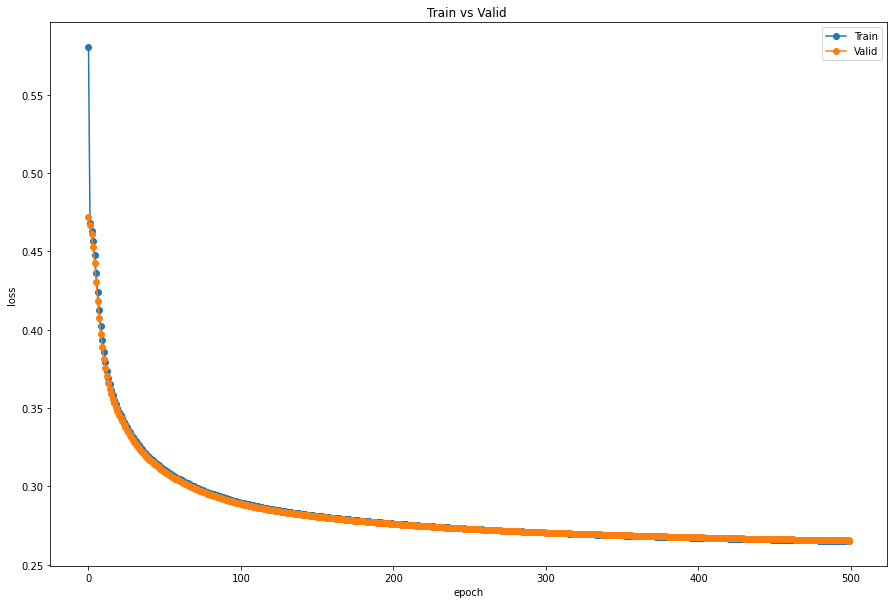

In [168]:
plt.figure(figsize=(15,10))
plt.plot(np.array(eval_dic['Loss_t'])/len(train_loader),'-o')
plt.plot(np.array(eval_dic['Loss_v'])/len(val_loader),'-o')
# plt.plot(losses_val,'-o')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid ')
# 


### Q1.f)
Reload the latest weights that you’ve saved during training, and make a prediction on
the test set. Compare this to the prediction made on the untrained model.
Plot two graphs side-by-side, 
1) Overlay the prediction from the untrained model and the trained model, 

2) The test set data. As usual, make sure to have the proper labels and legends.

Comment on your results.

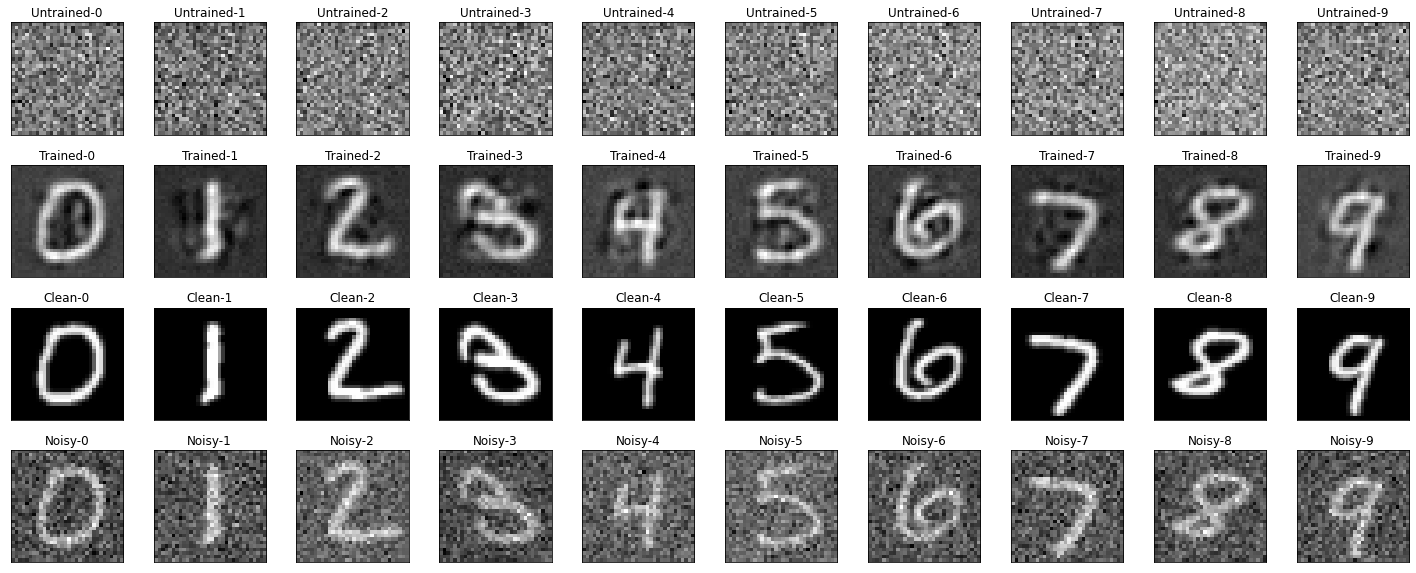

In [172]:
# get dataloader
test_loader
    
# get some examples
examples = enumerate(test_loader)
_, (x_clean_example, x_noisy_example, labels_example) = next(examples)

# use these example images througout the assignment as the first 10 correspond to the digits 0-9
model_untrained = FFNN_1b()
model = FFNN_1b()

# Fill your architecture with the trained weights
device = torch.device('cpu')
model.load_state_dict(torch.load(os.path.join("./", "Saved_Model.pth")))

model = model.to(device=device)
model_untrained = model_untrained.to(device=device)
with torch.no_grad():
    # score_clean = model(x_clean_example)
    score_noisy = model(x_noisy_example).resize(64,1,32,32).cpu()
    score_noisy_untrained = model_untrained(x_noisy_example).resize(64,1,32,32).cpu()
#     print(score_noisy.size())
#     print(x_noisy_example.size())

    # #take the maximum value of the prediction
    # _, pred_clean = torch.max(score_clean, 1)
    # _, pred_noisy = torch.max(score_noisy, 1)


    # show the examples in a plot
    plt.figure(figsize=(20,10))
    for i in range(10):
        plt.subplot(5,10,i+1)
#         plt.set_title('Clean Test Data')
        plt.gca().set_title('Untrained-'+str(i))
        plt.imshow(score_noisy_untrained[i,0,:,:],cmap='gray')
        plt.xticks([])
        plt.yticks([])
#         plt.title('Pred %d '% pred_clean[i].item())

        
        plt.subplot(5,10,i+11)
        plt.gca().set_title('Trained-'+str(i))
        plt.imshow(score_noisy[i,0,:,:],cmap='gray')
        
        plt.xticks([])
        plt.yticks([])
    
        plt.subplot(5,10, i+21)
        plt.imshow(x_clean_example[i,0,:,:],cmap='gray')
        plt.gca().set_title('Clean-'+str(i))
        plt.xticks([])
        plt.yticks([])
        
        plt.subplot(5,10, i+31)
        plt.gca().set_title('Noisy-'+str(i))
        plt.imshow(x_noisy_example[i,0,:,:],cmap='gray')
        plt.xticks([])
        plt.yticks([])
#         plt.title('Pred %d '% pred_noisy[i].item())

plt.tight_layout()
plt.savefig("data_examples.png",dpi=300,bbox_inches='tight')
plt.show()

### Q2.a)
Build an activation function (ReLU), and include it with the model. The definition
for a ReLU is given as,
f(x) = max(0, x) (1.8)
You may use the same network as before, but now use your own activation function as
the activation function (Do not use the ReLU activation function given by Pytorch)!
Plot the output from this activation function. 
* Does it match what you expect? 
* Where in the network does the activation function have to be implemented? 
Include your custom built activation in the network. Also include the code that you have written.

In [123]:
######################## Part a ###############################

class relu(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input):
        result = (input > 0) * input
        return result
    
# Redefine layers

class FFNN_2a(nn.Module):
    """
    A simple Feed Forward Neural Network
    
    Param
    ------------
    input_size : int (default = 32*32)         
        The length of the datasets which is width*height)
    n_hidden : int (default: 200)
        Number of hidden units.
    n_classes: int  (default = 10)        
        Number of the final classes, in our case 0-9 thus 10 classes.
    """
    def __init__(self, input_size=32*32, hidden_size= 512, n_classes=10):
        super().__init__()
        
        self.flat = nn.Flatten()
        # First fully connected layer
        self.fc1 = nn.Linear(input_size, 400)

        # Second fully connected layer
        self.fc2 = nn.Linear(400, 200)
        self.fc3 = nn.Linear(200, 500)
        self.fc4 = nn.Linear(500, input_size)

        #no activation functions yet
        self.activation = relu()
    
    def forward(self, x):
        # forward always defines connectivity
        x = self.flat(x)
        x = self.fc1(x)
#         x = self.activation(x)
        x = self.fc2(x)
#         x = self.activation(x)
        x = self.fc3(x)
        x = self.activation(x)
        y = self.fc4(x)
        return y

    def predict(self,x):
        """Predict class labels
        Parameters
        -----------
        X : array, shape = [n_samples, n_features]
            Input layer with original features.
        Returns:
        ----------
        y_pred : array, shape = [n_samples]
            Predicted class labels.
        """
        # Implement prediction here
        a_out = self.forward(x).detach().numpy()
        result = np.zeros(len(a_out))
        for i in range(len(a_out)):
            j = np.argmax(a_out[i])
            result[i] = j
        y_pred = result
        return y_pred
    
model = FFNN_2a()

Text(0, 0.5, 'ReLu(Input)')

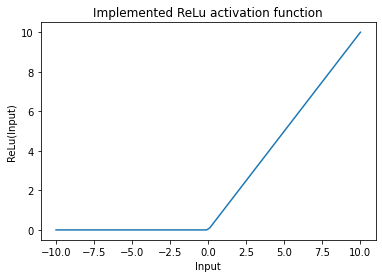

In [115]:
# TEST RELU

x = np.linspace(-10,10,num=100)
t = torch.tensor(x)

def RELU(input):
    #zeros = torch.tensor(np.zeros(input.shape[0],))
    #x = torch.stack((input, zeros), 1)
    #result = torch.max(x, 1)
    #return result.values
    result = (input > 0) * input
    return result

plt.plot(x,RELU(t).numpy())
plt.title("Implemented ReLu activation function")
plt.xlabel("Input")
plt.ylabel("ReLu(Input)")
# plt.savefig(r'C:\Users\20167271\Desktop\ML for signal processing\A1\relu.png')

### Q2.b) 
A second major factor can be the optimiser that you chose to perform this regression.
While SGD does as advertised, there are more sophisticated optimisers out there.
For the next round of training, pick a more sophisticated optimiser, and justify your
choice. 

* What are the problem that can occur with SGD and how are these resolved by more sophisticated optimizers?

SGD is slow and jiterry as the gradient is updated after mini-batches. Overall the computation is expensive if the batch is large or the entire dataset and innaccurate if the batch is too small. 
Adam on the other hand calculates first and second momentum of the gradient to overcome the jitter and bring momentum. It also helps againts being stuck at saddle points

### Q2.C)
As with exercise 1d, make a prediction using the untrained network using the test
data.
Comment on the prediction of the untrained network.

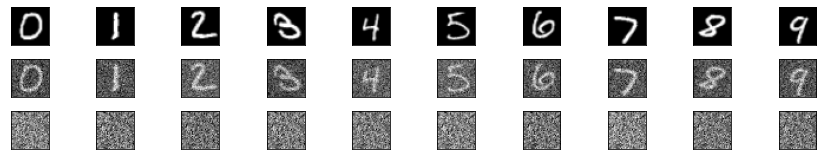

In [119]:
# define parameters
data_loc = 'D://5LSL0-Datasets' #change the datalocation to something that works for you
batch_size = 64
    
# get dataloader
test_loader
    
# get some examples
examples = enumerate(test_loader)
_, (x_clean_example, x_noisy_example, labels_example) = next(examples)

# Fill your architecture with the trained weights
device = torch.device('cpu')
model = model = FFNN_2a()
model = model.to(device=device)
with torch.no_grad():
    score_noisy = model(x_noisy_example).resize(64,1,32,32).cpu()
#     score_noisy_untrained = model_untrained(x_noisy_example).resize(64,1,32,32).cpu()



    # show the examples in a plot
    plt.figure(figsize=(12,3))
    for i in range(10):
        plt.subplot(4,10,i+1)
#         plt.set_title('Clean Test Data')
        plt.imshow(x_clean_example[i,0,:,:],cmap='gray')
        plt.xticks([])
        plt.yticks([])
#         plt.title('Pred %d '% pred_clean[i].item())

        plt.subplot(4,10,i+11)
#         plt.set_title('Noisy Test Data')
        plt.imshow(x_noisy_example[i,0,:,:],cmap='gray')
        plt.xticks([])
        plt.yticks([])
    
        plt.subplot(4,10, i+21)
#         plt.set_title('Predicted for trained')
        plt.imshow(score_noisy[i,0,:,:],cmap='gray')
        plt.xticks([])
        plt.yticks([])

plt.tight_layout()
plt.savefig("data_examples.png",dpi=300,bbox_inches='tight')
plt.show()

###  Q2.d)

Train this network, and ensure to save the weights from the training, so that you can
load it in later to make prediction.
Plot train and validation losses, like you did in exercise 1e.
At this point, it is good to reevaluate if the network architecture you have chosen is
appropriate for the problem you are trying to solve.

In [125]:
######################## Part d partial ###############################
# Import the model
model = FFNN_2a()

# flags
write_to_file = True # if you want to save the model paramters after training
USE_GPU = True # If you want to use GPU
# noise = True # If you want to train on the noisy data

# Parameters
batch_size = 64
epochs = 500
    
    # learning rate
learning_rate = 1e-4 
    #Loss-function
criterion = nn.MSELoss()
    #optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)  ## SGD optimizer




# trainer
dtype = torch.float32
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

model = model.to(device=device)

losses = []
losses_val = []

# create dictionary to keep track of training scores
eval_dicQ2 = {'Loss_t': [], 'train_acc': [],'Loss_v': [], 'valid_acc': []}
loss_train = []
loss_val = []

for i in range(epochs):
    running_loss = 0.0
    # train and compute the training loss
    for t, data in enumerate(train_loader):
        model.train() # put the model in training mode, only important for batchnorm- and dropout-layers
        x,xn,_ = data
        
        # cast the inputs to the device
        x = x.to(device=device, dtype=dtype)
        xn = xn.to(device=device, dtype=dtype)
        m = nn.Flatten()
        y = m(xn)
#         print(y.size())
        ######################## Training pass #################################
       
        # Zero out all of the parameter gradients for the variables which the optimizer
        # will update.
        optimizer.zero_grad()
        
        # Forward pass get the output prediction and the loss
        output = model(x)
        loss = criterion(output, y)

        # This is the backwards pass: compute the gradient of the loss with
        # respect to each  parameter of the model.
        loss.backward()
        
        # Actually update the parameters of the model using the gradients
        # computed by the backwards pass.
        optimizer.step()
        
        running_loss += loss.item()
    
    train_epoch_loss = running_loss#/len(train_loader)
    eval_dicQ2['Loss_t'].append(train_epoch_loss)
    
#     print(eval_dic['Loss_t'][i])
#         else:
#             test_loss = 0
#             accuracy = 0
        
            ########################### Validation pass ####################################
    # Turn off gradients for validation, saves memory and computation
    with torch.no_grad():
        running_loss_val = 0.0
#         Set the model to evaluation mode
        model.eval()

        for data in val_loader:
            # validation on noisy part or not
            x,xn,_ = data

            # cast the inputs to the device
            x = x.to(device=device, dtype=dtype)
            xn = xn.to(device=device, dtype=dtype)
            m = nn.Flatten()
            y = m(xn)

            output = model(x)
            loss = criterion(output, y)
            running_loss_val += loss.item()
        val_epoch_loss = running_loss_val#/len(val_loader)
        eval_dicQ2['Loss_v'].append(val_epoch_loss)
    print('Epoch', i)
    print('Training Loss', eval_dicQ2['Loss_t'][i])
    print('Checking accuracy validation set')
    print('Validation Loss', eval_dicQ2['Loss_v'][i])
   
    # Save the model paramters
    if write_to_file:        
        # Save the weights of the model to a .pt file
        torch.save(model.state_dict(), os.path.join("./", "Saved_ModelQ2.pth"))

Epoch 0
Training Loss 338.92005383968353
Checking accuracy validation set
Validation Loss 47.16445568203926
Epoch 1
Training Loss 272.9079487025738
Checking accuracy validation set
Validation Loss 44.53768491744995
Epoch 2
Training Loss 262.6705170571804
Checking accuracy validation set
Validation Loss 43.432438403367996
Epoch 3
Training Loss 257.5374371409416
Checking accuracy validation set
Validation Loss 42.8073653280735
Epoch 4
Training Loss 254.41720658540726
Checking accuracy validation set
Validation Loss 42.34711670875549
Epoch 5
Training Loss 252.23078233003616
Checking accuracy validation set
Validation Loss 42.07299807667732
Epoch 6
Training Loss 250.61274114251137
Checking accuracy validation set
Validation Loss 41.868615716695786
Epoch 7
Training Loss 249.35706821084023
Checking accuracy validation set
Validation Loss 41.67319667339325
Epoch 8
Training Loss 248.31919166445732
Checking accuracy validation set
Validation Loss 41.52521416544914
Epoch 9
Training Loss 247.4373

Epoch 76
Training Loss 238.32741954922676
Checking accuracy validation set
Validation Loss 40.25011694431305
Epoch 77
Training Loss 238.2949365824461
Checking accuracy validation set
Validation Loss 40.22689229249954
Epoch 78
Training Loss 238.26234562695026
Checking accuracy validation set
Validation Loss 40.23245307803154
Epoch 79
Training Loss 238.2327775210142
Checking accuracy validation set
Validation Loss 40.23456168174744
Epoch 80
Training Loss 238.20432567596436
Checking accuracy validation set
Validation Loss 40.224635273218155
Epoch 81
Training Loss 238.18752194941044
Checking accuracy validation set
Validation Loss 40.234412372112274
Epoch 82
Training Loss 238.1507946252823
Checking accuracy validation set
Validation Loss 40.22432550787926
Epoch 83
Training Loss 238.12028405070305
Checking accuracy validation set
Validation Loss 40.202265590429306
Epoch 84
Training Loss 238.09318454563618
Checking accuracy validation set
Validation Loss 40.21350300312042
Epoch 85
Training L

Epoch 151
Training Loss 236.96599459648132
Checking accuracy validation set
Validation Loss 40.14403855800629
Epoch 152
Training Loss 236.95252184569836
Checking accuracy validation set
Validation Loss 40.15253919363022
Epoch 153
Training Loss 236.9406011402607
Checking accuracy validation set
Validation Loss 40.13243645429611
Epoch 154
Training Loss 236.93549117445946
Checking accuracy validation set
Validation Loss 40.143182426691055
Epoch 155
Training Loss 236.92884188890457
Checking accuracy validation set
Validation Loss 40.15036183595657
Epoch 156
Training Loss 236.90866945683956
Checking accuracy validation set
Validation Loss 40.15259364247322
Epoch 157
Training Loss 236.8900312334299
Checking accuracy validation set
Validation Loss 40.139325737953186
Epoch 158
Training Loss 236.8853862285614
Checking accuracy validation set
Validation Loss 40.135173350572586
Epoch 159
Training Loss 236.87779104709625
Checking accuracy validation set
Validation Loss 40.16055229306221
Epoch 160


Epoch 226
Training Loss 236.36200796067715
Checking accuracy validation set
Validation Loss 40.138719379901886
Epoch 227
Training Loss 236.3586840480566
Checking accuracy validation set
Validation Loss 40.13253939151764
Epoch 228
Training Loss 236.34007711708546
Checking accuracy validation set
Validation Loss 40.15029275417328
Epoch 229
Training Loss 236.3305210918188
Checking accuracy validation set
Validation Loss 40.143101185560226
Epoch 230
Training Loss 236.3327036499977
Checking accuracy validation set
Validation Loss 40.137476444244385
Epoch 231
Training Loss 236.32162864506245
Checking accuracy validation set
Validation Loss 40.13503769040108
Epoch 232
Training Loss 236.32291388511658
Checking accuracy validation set
Validation Loss 40.15683242678642
Epoch 233
Training Loss 236.30992445349693
Checking accuracy validation set
Validation Loss 40.15973788499832
Epoch 234
Training Loss 236.30164593458176
Checking accuracy validation set
Validation Loss 40.145111322402954
Epoch 235

Epoch 301
Training Loss 235.96502079069614
Checking accuracy validation set
Validation Loss 40.15956398844719
Epoch 302
Training Loss 235.95125964283943
Checking accuracy validation set
Validation Loss 40.16104128956795
Epoch 303
Training Loss 235.9602905511856
Checking accuracy validation set
Validation Loss 40.172555446624756
Epoch 304
Training Loss 235.95814561843872
Checking accuracy validation set
Validation Loss 40.16451358795166
Epoch 305
Training Loss 235.94130347669125
Checking accuracy validation set
Validation Loss 40.16595438122749
Epoch 306
Training Loss 235.9419772028923
Checking accuracy validation set
Validation Loss 40.1597156226635
Epoch 307
Training Loss 235.94140370190144
Checking accuracy validation set
Validation Loss 40.1738378405571
Epoch 308
Training Loss 235.9420841038227
Checking accuracy validation set
Validation Loss 40.16125562787056
Epoch 309
Training Loss 235.9394795000553
Checking accuracy validation set
Validation Loss 40.174094289541245
Epoch 310
Trai

Epoch 376
Training Loss 235.67572024464607
Checking accuracy validation set
Validation Loss 40.179982751607895
Epoch 377
Training Loss 235.67468789219856
Checking accuracy validation set
Validation Loss 40.17856150865555
Epoch 378
Training Loss 235.671352699399
Checking accuracy validation set
Validation Loss 40.18854957818985
Epoch 379
Training Loss 235.66993883252144
Checking accuracy validation set
Validation Loss 40.18329653143883
Epoch 380
Training Loss 235.66425108909607
Checking accuracy validation set
Validation Loss 40.180264323949814
Epoch 381
Training Loss 235.6620555371046
Checking accuracy validation set
Validation Loss 40.18389305472374
Epoch 382
Training Loss 235.65462937951088
Checking accuracy validation set
Validation Loss 40.20125809311867
Epoch 383
Training Loss 235.65035688877106
Checking accuracy validation set
Validation Loss 40.18409439921379
Epoch 384
Training Loss 235.65858821570873
Checking accuracy validation set
Validation Loss 40.192204654216766
Epoch 385


Epoch 451
Training Loss 235.4547063410282
Checking accuracy validation set
Validation Loss 40.19967848062515
Epoch 452
Training Loss 235.4589351862669
Checking accuracy validation set
Validation Loss 40.193213760852814
Epoch 453
Training Loss 235.45218662917614
Checking accuracy validation set
Validation Loss 40.20117035508156
Epoch 454
Training Loss 235.4508408010006
Checking accuracy validation set
Validation Loss 40.212090492248535
Epoch 455
Training Loss 235.44322974979877
Checking accuracy validation set
Validation Loss 40.21534678339958
Epoch 456
Training Loss 235.44671180844307
Checking accuracy validation set
Validation Loss 40.21244069933891
Epoch 457
Training Loss 235.44204753637314
Checking accuracy validation set
Validation Loss 40.19769987463951
Epoch 458
Training Loss 235.44128294289112
Checking accuracy validation set
Validation Loss 40.215795040130615
Epoch 459
Training Loss 235.43400111794472
Checking accuracy validation set
Validation Loss 40.19656500220299
Epoch 460


Text(0.5, 1.0, 'Train vs Valid ')

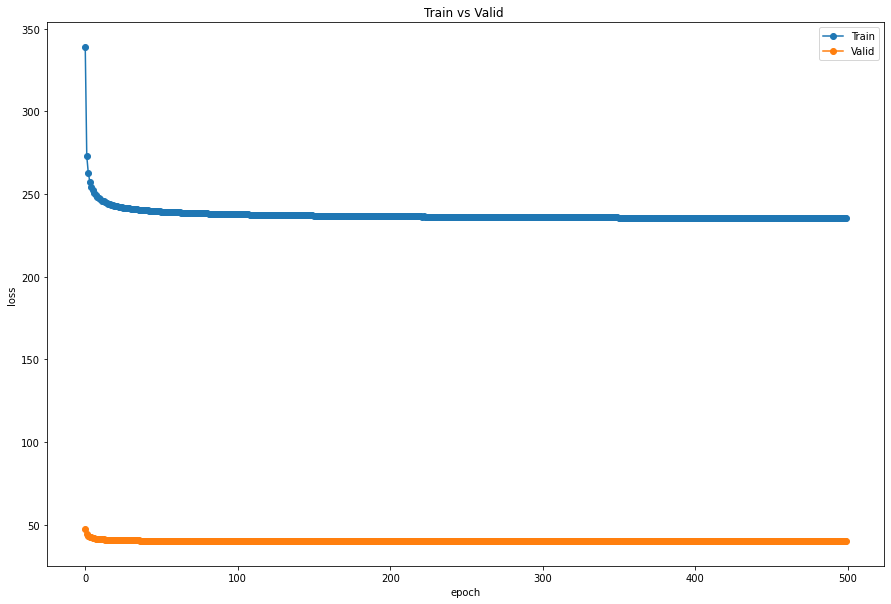

In [170]:
plt.figure(figsize=(15,10))
plt.plot(np.array(eval_dicQ2['Loss_t']),'-o')
plt.plot(np.array(eval_dicQ2['Loss_v']),'-o')
# plt.plot(losses_val,'-o')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid ')

### Q2.e) 
Load the latest weights from the training process, and make a prediction.
Plot the predictions from the trained and the untrained model on separate rows, and
include the corresponding clean image in the third row.
Compare the prediction made by the first trained model (from Exercise one), to the
prediction made by the second trained model (from Exercise two). Also comment on
the differences between the two models that you have implemented.

C:\Users\Jexel\anaconda3\envs\PGPUC\lib\site-packages\torch\_tensor.py:549: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


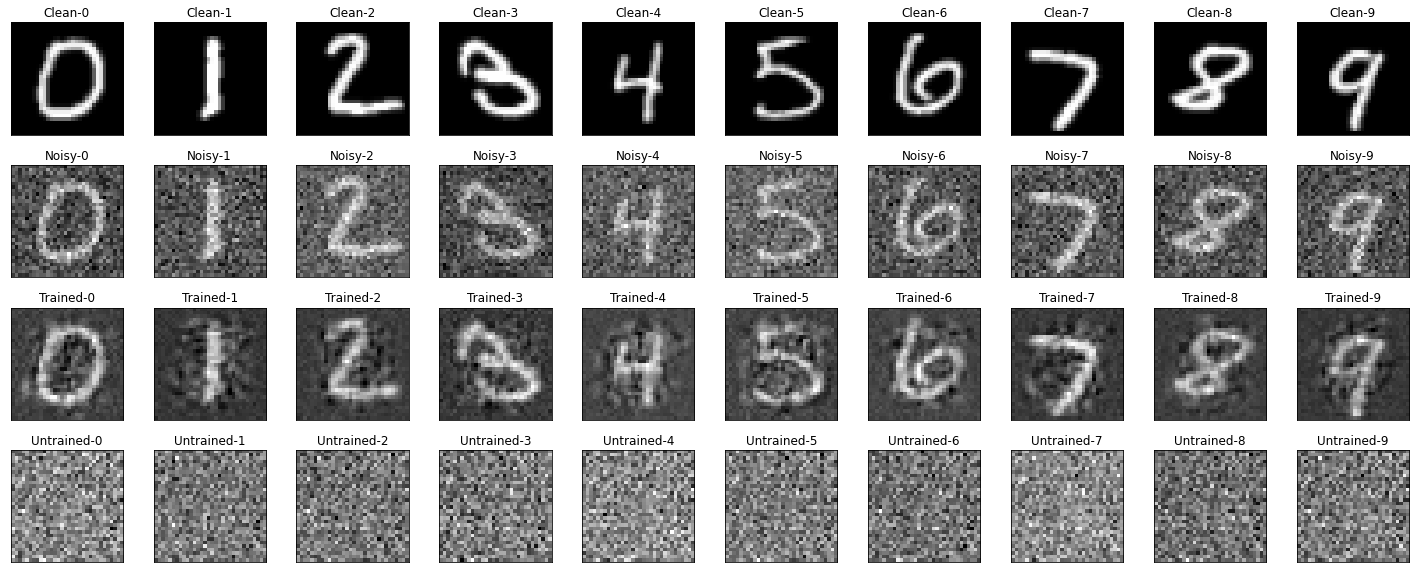

In [171]:
# get dataloader
test_loader
    
# get some examples
examples = enumerate(test_loader)
_, (x_clean_example, x_noisy_example, labels_example) = next(examples)

# use these example images througout the assignment as the first 10 correspond to the digits 0-9
model_untrained = FFNN_2a()
model = FFNN_2a()

# Fill your architecture with the trained weights
device = torch.device('cpu')
model.load_state_dict(torch.load(os.path.join("./", "Saved_ModelQ2.pth")))

model = model.to(device=device)
model_untrained = model_untrained.to(device=device)
with torch.no_grad():
    # score_clean = model(x_clean_example)
    score_noisy = model(x_noisy_example).resize(64,1,32,32).cpu()
    score_noisy_untrained = model_untrained(x_noisy_example).resize(64,1,32,32).cpu()
#     print(score_noisy.size())
#     print(x_noisy_example.size())

    # #take the maximum value of the prediction
    # _, pred_clean = torch.max(score_clean, 1)
    # _, pred_noisy = torch.max(score_noisy, 1)


    # show the examples in a plot
    plt.figure(figsize=(20,10))
    for i in range(10):
        plt.subplot(5,10,i+1)
#         plt.set_title('Clean Test Data')
        plt.imshow(x_clean_example[i,0,:,:],cmap='gray')
        plt.xticks([])
        plt.yticks([])
#         plt.title('Pred %d '% pred_clean[i].item())
        plt.gca().set_title('Clean-'+str(i))
        
        plt.subplot(5,10,i+11)
        plt.gca().set_title('Noisy-'+str(i))
        plt.imshow(x_noisy_example[i,0,:,:],cmap='gray')
        plt.xticks([])
        plt.yticks([])
    
        plt.subplot(5,10, i+21)
        plt.gca().set_title('Trained-'+str(i))
        plt.imshow(score_noisy[i,0,:,:],cmap='gray')
        plt.xticks([])
        plt.yticks([])
        
        plt.subplot(5,10, i+31)
        plt.gca().set_title('Untrained-'+str(i))
        plt.imshow(score_noisy_untrained[i,0,:,:],cmap='gray')
        plt.xticks([])
        plt.yticks([])
#         plt.title('Pred %d '% pred_noisy[i].item())

plt.tight_layout()
plt.savefig("data_examples.png",dpi=300,bbox_inches='tight')
plt.show()

### Q2.f)
A deeper architecture is not always a better architecture as the gradient becomes harder to backpropagate leading to the vanishing gradient problem 